In [15]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from IPython.display import clear_output, display
import tensorflow as tf

<Figure size 432x288 with 0 Axes>

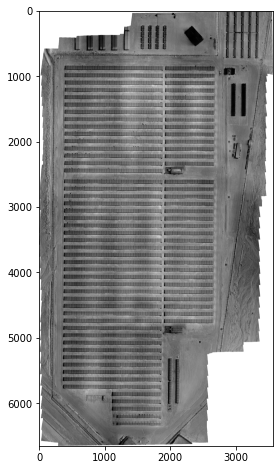

In [81]:
path_T = "El_Aguila_2020/Thermo.tif"
path_save_list = "El_Aguila_2020/List_strings_panels_PV03.txt"
path_save_list_print = "El_Aguila_2020/List_strings_panels_print_PV03.txt"

GR_T = gr.from_file(path_T)

## Load List in coordinate latitud and longitude  to pixels ###
with open(path_save_list, "rb") as fp:
    L_strings_coord_load = pickle.load(fp)

plt.figure(0)
plt.figure(figsize=(8, 8))
plt.imshow(GR_T.raster.data[0,:,:], cmap = 'gray')

# Load Classifier

In [82]:
'''
path_dataset = "Classifier/dataset_prueba_1/"
output_recognizer = path_dataset + "model_SVM/recognizer.pickle"
output_label = path_dataset + "model_SVM/le.pickle"

# load the actual face recognition model along with the label encoder
classifier = pickle.loads(open(output_recognizer, "rb").read())
le = pickle.loads(open(output_label, "rb").read())


img_width, img_height = 224, 224

base_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)
x = base_model.output
x  = tf.keras.layers.GlobalAveragePooling2D()(x)
base_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
'''

'\npath_dataset = "Classifier/dataset_prueba_1/"\noutput_recognizer = path_dataset + "model_SVM/recognizer.pickle"\noutput_label = path_dataset + "model_SVM/le.pickle"\n\n# load the actual face recognition model along with the label encoder\nclassifier = pickle.loads(open(output_recognizer, "rb").read())\nle = pickle.loads(open(output_label, "rb").read())\n\n\nimg_width, img_height = 224, 224\n\nbase_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3), weights=\'imagenet\', include_top=False)\nx = base_model.output\nx  = tf.keras.layers.GlobalAveragePooling2D()(x)\nbase_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)\n'

#  Panel Classification

In [83]:
'''

        
epsilon = 0
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]

#geot = GR_RGB.geot
geot = GR_T.geot


for string_key in ['6', '10']:# L_strings_coord_load.keys():
    print(string_key)
    string = L_strings_coord_load[string_key]
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        Points =  Utils.gps2pixel(panel['points'], geot) + matrix_expand_bounds
        
        if not GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]].size == 0:
            Im = np.zeros((img_height, img_width, 3))
            Im[:,:,0] = cv2.resize(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]], (img_width, img_height))
            Im[:,:,1] = Im[:,:,0].copy()
            Im[:,:,2] = Im[:,:,0].copy()
            v = base_model.predict(tf.keras.backend.expand_dims(Im,0)).flatten()
            falla = le.classes_[classifier.predict(tf.keras.backend.expand_dims(v,0))][0]
            panel['prob'] = np.max(classifier.predict_proba(tf.keras.backend.expand_dims(v,0)))
            if panel['prob'] < .5 and falla != le.classes_[0]:
                panel['status'] = le.classes_[0]
            else:
                panel['status'] = falla
        else:
            print('problem with coords panel: ', string_key, '_', panel_key)

'''

"\n\n        \nepsilon = 0\nmatrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]\n\n#geot = GR_RGB.geot\ngeot = GR_T.geot\n\n\nfor string_key in ['6', '10']:# L_strings_coord_load.keys():\n    print(string_key)\n    string = L_strings_coord_load[string_key]\n    for panel_key in string['panels'].keys():\n        panel = string['panels'][panel_key]\n        Points =  Utils.gps2pixel(panel['points'], geot) + matrix_expand_bounds\n        \n        if not GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]].size == 0:\n            Im = np.zeros((img_height, img_width, 3))\n            Im[:,:,0] = cv2.resize(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]], (img_width, img_height))\n            Im[:,:,1] = Im[:,:,0].copy()\n            Im[:,:,2] = Im[:,:,0].copy()\n            v = base_model.predict(tf.keras.backend.expand_dims(Im,0)).flatten()\n            falla = le.classes_[classi

# T° mean string and panel

In [84]:
epsilon = 0
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]
t_min = np.min(GR_T.raster.data)
t_max = np.max(GR_T.raster.data)
t_new_min = 0
t_new_max = 70

geot = GR_T.geot

for string_key in L_strings_coord_load.keys():
    clear_output(wait=True)
    print(string_key)
    string = L_strings_coord_load[string_key]
    Points =  Utils.gps2pixel(string['points'], geot) + matrix_expand_bounds
    string['T'] = t_new_min + (t_new_max - t_new_min) * np.mean(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]]) / (t_max - t_min)
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        Points =  Utils.gps2pixel(panel['points'], geot) + matrix_expand_bounds
        panel['T'] = t_new_min + (t_new_max - t_new_min) * np.mean(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]]) / (t_max - t_min)
        

3


<Figure size 432x288 with 0 Axes>

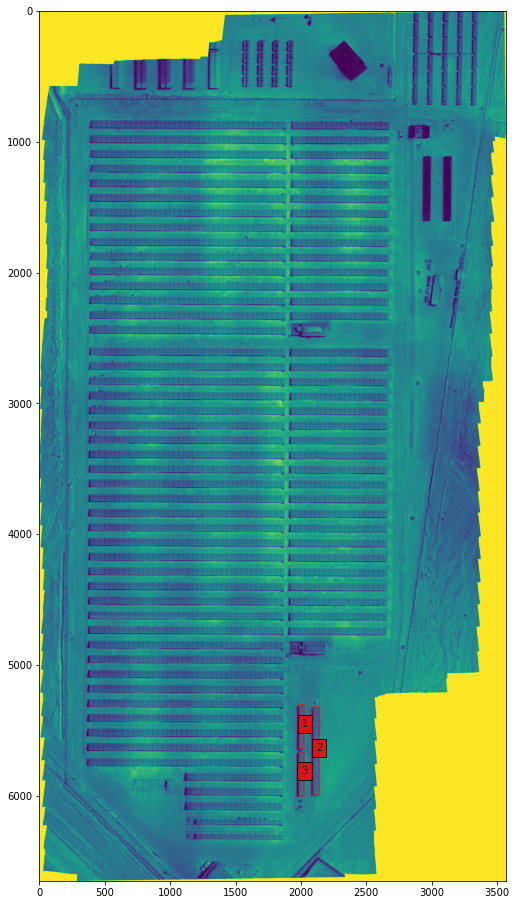

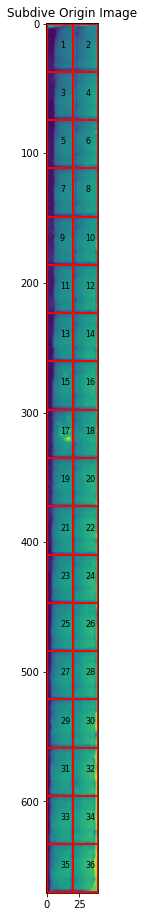

In [86]:
geot = GR_T.geot

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(GR_T.raster.data[0,:,:])

ax = plt.gca()

for Poly_key in L_strings_coord_load.keys():
    
    Poly = L_strings_coord_load[Poly_key]
    poly = patches.Polygon( Utils.gps2pixel(Poly['points'], geot),
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Utils.gps2pixel(Poly['points'], geot)]), np.mean([y[1]  for y in Utils.gps2pixel(Poly['points'], geot)]) , str(Poly['id']),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)
    


string = L_strings_coord_load['2']
panels = string['panels']
Points = Utils.gps2pixel(string['points'], geot) 

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(GR_T.raster[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])
#plt.imshow((GR_RGB.raster[:3,:,:]).transpose((1, 2, 0))[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])

plt.title('Subdive Origin Image')
ax = plt.gca()

for Poly_key in panels.keys():
    
    Poly = panels[Poly_key]
    poly = patches.Polygon(Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1]),
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1])]), np.mean([y[1]  for y in Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1])]) , 
             str(Poly['id']),  bbox=dict(facecolor='red', alpha=0.0), fontsize=8)

    ax.add_patch(poly)

In [88]:
for i in [17]:#[12,13,14,15,16,17]:
    L_strings_coord_load['2']['panels'][str(i)]['status'] = '3.Más de 5 celdas afect.'

In [89]:
with open(path_save_list, "wb") as fp:
    pickle.dump(L_strings_coord_load, fp)
with open(path_save_list_print, 'w') as f:
    print(L_strings_coord_load, file=f)


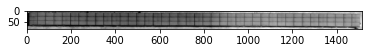

In [35]:
epsilon = 10
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]


Points =  Utils.gps2pixel(L_strings_coord_load['1']['points'], geot) + matrix_expand_bounds
plt.figure(figsize=(6, 6))
plt.imshow(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]],cmap = 'gray')

#plt.figure(0)
#plt.figure(figsize=(6, 6))
#plt.imshow(cv2.resize(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]], (224, 224)),cmap = 'gray')
#plt.imshow((GR_RGB.raster[:3,:,:]).transpose((1, 2, 0))[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])


0